In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import fastai
from random import randint
from fastai.text import SortishSampler
from fastai.basic_data import DataBunch

c:\users\donatas\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\donatas\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
ROOT = "../../data/protein/structure/secondary_structure/"
DATA_PATH = ROOT+"sample_1_kmers"
EMBEDDING_PATH = "../../data/protein/classification/data_sources/protVec_100d_3grams.csv"
MODEL_PATH = "../../weights/protein/structure/secondary_structure/1_kmers/"
SEQUENCE_LENGTH=729
NUM_CLASSES = 9

In [3]:
features = np.array([16, 32, 64, 128, 256])
num_workers = 0 # On cloud 8
batch_size = 16

In [4]:
features

array([ 16,  32,  64, 128, 256])

In [5]:
class EnzymeDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, transform=None):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        return np.int64(row[0]), np.int64(row[1])

In [6]:
embeddings = np.random.uniform(low=-1, high=1, size=[21, 100])
#embeddings = np.loadtxt(open(EMBEDDING_PATH, "rb"), delimiter="\t", skiprows=1, usecols=[i for i in range(1,101)])

In [7]:
train = np.load(DATA_PATH+"/train/data.npy")
val = np.load(DATA_PATH+"/val/data.npy")
test = np.load(DATA_PATH+"/test/data.npy")

In [8]:
len(train)

8063

In [9]:
train_sampler = SortishSampler(train, key=lambda x: len(train[x][0]), bs=batch_size//2)
val_sampler = SortishSampler(val, key=lambda x: len(val[x][0]), bs=batch_size//2)
test_sampler = SortishSampler(test, key=lambda x: len(test[x][0]), bs=batch_size//2)

In [10]:
def pad_tensor(seq, label, length):
    seq_len = len(seq)
    to_pad = length - seq_len
    end_padding = randint(0, to_pad)
    begin_padding = to_pad - end_padding
    seq = np.pad(seq, mode="constant", pad_width=(begin_padding,end_padding))
    label = np.pad(label, mode="constant", pad_width=(begin_padding,end_padding))
    return seq,label

In [11]:
def pad_collate(samples, random=True):
    "Function that collect samples and adds padding."
    max_len = max(64 ,max(map(lambda x: len(x[0]), samples)))
    batch = list(map(lambda x: pad_tensor(x[0], x[1], max_len), samples))
    # stack all
    x = torch.stack([torch.from_numpy(b[0]) for b in batch], 0)
    y = torch.stack([torch.from_numpy(b[1]) for b in batch], 0)
    return x, y

In [12]:
train_ds = EnzymeDataSet(train)
val_ds = EnzymeDataSet(val)
test_ds = EnzymeDataSet(test)

In [13]:
dls = [DataLoader(*o, num_workers=num_workers) for o in
       zip((train_ds, val_ds, test_ds), (batch_size,batch_size*2,batch_size*2), 
           (False,False,False), (train_sampler, val_sampler, test_sampler))]
data = DataBunch(*dls, collate_fn=pad_collate)

In [14]:
class UnetDown(nn.Module):

    def __init__(self, num_inputs, num_outputs, kernel_size, strides, dilation_rate=1, dropout=0.2, act=F.selu, pool=True):
        super(UnetDown, self).__init__()
        self.act = act
        self.conv1 = nn.Conv1d(num_inputs, num_inputs, kernel_size, stride=1, dilation = 1)
        self.conv2 = nn.Conv1d(num_inputs, num_inputs, kernel_size, stride=1, dilation = dilation_rate)
        self.pool = nn.Conv1d(num_inputs, num_outputs, kernel_size, stride=strides, dilation = 1)
        self.bn1 = nn.BatchNorm1d(num_inputs)
        self.bn2 = nn.BatchNorm1d(num_inputs)
        self.to_pool = pool
        before = (kernel_size -1) // 2
        after = (kernel_size -1) - before
        self.padding = nn.ReflectionPad1d((before,after))
        stride_padding = (strides - 1) // 2
        self.padding_stride = nn.ReflectionPad1d((before-stride_padding, after -((strides - 1)-stride_padding)))
        
    def forward(self, x):
        out = self.conv1(self.padding(x))
        out = self.act(self.bn1(out))
        out = self.conv2(self.padding(out))
        before_pooling = self.act(self.bn2(out))
        if self.to_pool:
            out = self.pool(self.padding_stride(before_pooling))
            return out, before_pooling
        else:
            return before_pooling

In [15]:
class UnetUp(nn.Module):
    def __init__(self,  num_inputs, num_outputs, kernel_size, strides, dilation_rate=1, dropout=0.2, act=F.relu):
        super(UnetUp, self).__init__()
        self.act = act
        self.up = nn.ConvTranspose1d(num_inputs, num_outputs, kernel_size, stride=strides, dilation = 1, padding=2)
        self.conv1 = nn.Conv1d(num_outputs*2, num_outputs, kernel_size, stride=1, dilation = dilation_rate, padding=2)
        self.conv2 = nn.Conv1d(num_outputs, num_outputs, kernel_size, stride=1, dilation = 1, padding=2)
        
        self.bn1 = nn.BatchNorm1d(num_outputs)
        self.bn2 = nn.BatchNorm1d(num_outputs)
        
    def forward(self, x, across):      
        out = self.up(x)
        #print(x.shape, out.shape, across.shape)
        if out.shape[2] != across.shape[2]:
            padding = abs(out.shape[2] - across.shape[2])            
            out = nn.ReflectionPad1d((padding//2, padding - (padding//2)))(out)

        out = torch.cat([out, across], 1)

        out = self.conv1(out)
        out = self.act(self.bn1(out))
        out = self.conv2(out)
        out = self.act(self.bn2(out))
        return out

In [16]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        #Encoder
        self.embedding = nn.Embedding(embeddings.shape[0], embeddings.shape[1])
        #self.embedding.from_pretrained(torch.from_numpy(embeddings)) 
        self.emb_cov = nn.Conv1d(embeddings.shape[1], features[0], 1)
        self.unet_down1 = UnetDown(features[0], features[1], 5, 2)   
        self.unet_down2 = UnetDown(features[1], features[2], 5, 2)  
        self.unet_down3 = UnetDown(features[2], features[3], 5, 2)
        self.unet_down4 = UnetDown(features[3], features[4], 5, 2)        
        
        self.center = UnetDown(features[4], features[4], 5, 1, pool=False)        
        #Decoder
        self.unet_block1 = UnetUp(features[4], features[3], 5, 2)   
        self.unet_block2 = UnetUp(features[3], features[2], 5, 2)  
        self.unet_block3 = UnetUp(features[2], features[1], 5, 2)
        self.unet_block4 = UnetUp(features[1], features[0], 5, 2)
        self.classification = nn.Conv1d(features[0], NUM_CLASSES, 1)

    def forward(self, x):
        embedded_seq = self.embedding(x)
        embedded_seq.transpose_(1, 2)
        embedded_seq = self.emb_cov(embedded_seq)
        d1, before_pooling1 = self.unet_down1(embedded_seq)
        d2, before_pooling2 = self.unet_down2(d1)
        d3, before_pooling3 = self.unet_down3(d2)   
        d4, before_pooling4 = self.unet_down4(d3)
        
        c = self.center(d4)
        
        u1 = self.unet_block1(c, before_pooling4)
        u2 = self.unet_block2(u1, before_pooling3)
        u3 = self.unet_block3(u2, before_pooling2) 
        u4 = self.unet_block4(u3, before_pooling1) 
        output = self.classification(u4)
        return output

In [17]:
def accuracy(input, targs):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    mask = (targs > 0)
    targs = targs.masked_select(mask)
    input = input.argmax(dim=1)
    input = input.masked_select(mask)
    return (input==targs).float().mean()

In [18]:
unet = Unet().cuda()

In [19]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.0001, 1, 1, 1, 1, 1, 1, 1, 1]).cuda())
optimizer = optim.Adam(unet.parameters(), lr=0.001)

In [20]:
learner = fastai.basic_train.Learner(data, unet, 
        loss_func=criterion, 
        metrics=accuracy, 
        path=None, 
        model_dir='models')

In [44]:
learner.fit_one_cycle(5)

Total time: 07:21
epoch  train_loss  valid_loss  accuracy
1      1.153437    1.247020    0.549264  (01:28)
2      1.155325    1.153033    0.581796  (01:27)
3      1.136606    1.144357    0.585312  (01:27)
4      1.121035    1.115583    0.597874  (01:28)
5      1.116804    1.098015    0.605238  (01:28)



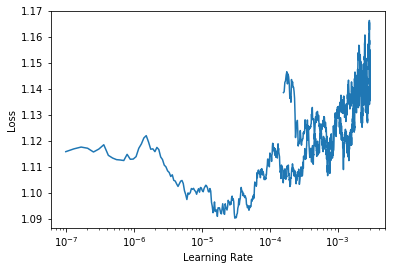

In [45]:
learner.recorder.plot()

In [46]:
preds, truth = learner.get_preds(is_test=True, n_batch=1)

In [47]:
accuracy(preds, truth)

tensor(0.5709)

In [48]:
acc = []
min_element = 0
min_score = 1
s = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s_t = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for row in range(len(truth)):

    a = preds.argmax(dim=1)[row]
    correct = 0
    actual = 0
    for i, t in enumerate(truth[row]):
        s[t] = s[t]+1
        if t != 0: # and t != 1:
            actual += 1
            if a[i] == t:        
                correct += 1
                s_t[t] = s_t[t]+1
    score = correct/actual
    if min_score > score:
        min_score = score
        min_element = row
    acc.append(score)

print(np.mean(acc))

0.5907144832624498


In [49]:
np.array(s_t)/np.array(s)

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.      , 0.      , 0.576728, 0.704385, 0.044444, 0.793362,      nan, 0.042005, 0.353723])

In [50]:
s_t, s

([0, 0, 1368, 1494, 18, 2223, 0, 31, 399],
 [13348, 126, 2372, 2121, 405, 2802, 0, 738, 1128])

In [51]:
print(min_score)
preds.argmax(dim=1)[min_element], truth[min_element]

0.3132530120481928


(tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 8, 7,
         2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 8, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         2, 8, 8, 2, 2, 2, 5, 3, 3, 3, 3, 3, 8, 7, 2, 2, 2, 2, 3, 8, 8, 2, 3, 3,
         3, 3, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0